# Decision tree classifier: diabetes prediction

Absolutely minimal MVP (minimum viable product) solution.

## 1. Data acquisition

### 1.1. Load

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
data_url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
data_df = pd.read_csv(data_url)

# Replace zero values in specific columns with NaN
zero_value_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data_df[zero_value_columns] = data_df[zero_value_columns].replace(0, np.nan)

# Separate features and labels
labels = data_df['Outcome']
features = data_df.drop('Outcome', axis=1)

# Split the data into training and testing sets
training_features, testing_features, training_labels, testing_labels = train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=315
)

# Impute missing values in training and testing sets
imputer = SimpleImputer(strategy='median')
training_features[zero_value_columns] = imputer.fit_transform(training_features[zero_value_columns])
testing_features[zero_value_columns] = imputer.transform(testing_features[zero_value_columns])

# Identify categorical columns
categorical_cols = training_features.select_dtypes(include=['object']).columns.tolist()

# Define preprocessing pipeline for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Apply preprocessing to training and testing features
training_features = preprocessor.fit_transform(training_features)
testing_features = preprocessor.transform(testing_features)

# Perform feature selection using RFE
model = DecisionTreeClassifier(random_state=315)
rfe_selector = RFE(estimator=model, n_features_to_select=5, step=1)
rfe_selector = rfe_selector.fit(training_features, training_labels)

# Use only selected features
selected_feature_names = features.columns[rfe_selector.support_]
training_features = training_features[:, rfe_selector.support_]
testing_features = testing_features[:, rfe_selector.support_]

# Train the Decision Tree model
model.fit(training_features, training_labels)

# Predict on the test set
predictions = model.predict(testing_features)

# Evaluate model performance
accuracy = accuracy_score(testing_labels, predictions)
conf_matrix = confusion_matrix(testing_labels, predictions)
class_report = classification_report(testing_labels, predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Perform hyperparameter optimization
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search.fit(training_features, training_labels)

# Best model and its performance
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_predictions = best_model.predict(testing_features)
best_accuracy = accuracy_score(testing_labels, best_predictions)

print(f"\nBest Hyperparameters: {best_params}")
print(f"Test Accuracy of Best Model: {best_accuracy * 100:.2f}%")

# Evaluate the optimized model with cross-validation
def cross_val(model, features, labels):
    """Helper function to perform cross-validation and return scores."""
    cross_validation = StratifiedKFold(n_splits=7, shuffle=True, random_state=315)
    scores = cross_val_score(model, features, labels, cv=cross_validation, n_jobs=-1, scoring='accuracy')
    print(f'Cross-validation accuracy: {scores.mean() * 100:.2f}% +/- {scores.std() * 100:.2f}%')
    return scores

cv_scores = cross_val(best_model, training_features, training_labels)

# Final evaluation
final_predictions = best_model.predict(testing_features)
final_accuracy = accuracy_score(testing_labels, final_predictions)
conf_matrix = confusion_matrix(testing_labels, final_predictions)
class_report = classification_report(testing_labels, final_predictions)

print(f"\nFinal Model Accuracy: {final_accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 72.08%

Confusion Matrix:
[[80 19]
 [24 31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        99
           1       0.62      0.56      0.59        55

    accuracy                           0.72       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.72      0.72      0.72       154


Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy of Best Model: 75.97%
Cross-validation accuracy: 75.90% +/- 5.83%

Final Model Accuracy: 75.97%

Confusion Matrix:
[[85 14]
 [23 32]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82        99
           1       0.70      0.58      0.63        55

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.75       154



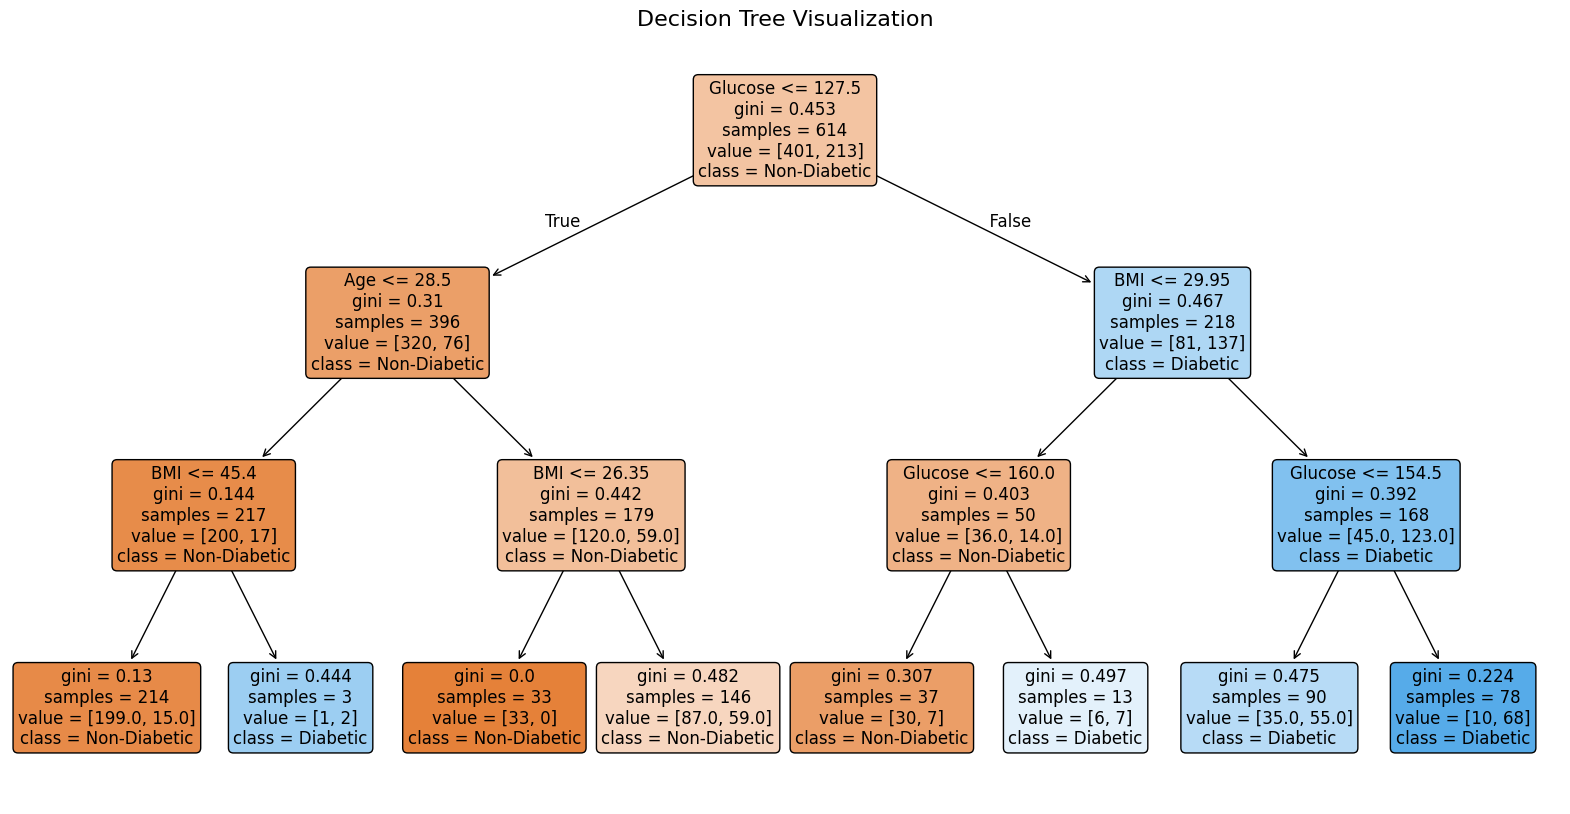

In [6]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_model,  # Use the optimized model
    feature_names=selected_feature_names,  # Names of the selected features
    class_names=['Non-Diabetic', 'Diabetic'],  # Class labels
    filled=True,  # Fill nodes with colors
    rounded=True,  # Rounded corners
    fontsize=12  # Font size
)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()
